# Определение локации для нефтедобычи

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 

### Шаг 1. Загрузка и подготовка данных

Для начала импортируем все библиотеки, потребующиеся в данной работе.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import f1_score
# from sklearn.metrics import roc_auc_score
# from sklearn.utils import shuffle
# from sklearn.metrics import roc_curve
# from sklearn.metrics import plot_confusion_matrix

Далее прочитаем файлы с данными и изучим общую информацию.

In [2]:
# Пути к файлам на локальком компьютере
paths = ['datasets/geo_data_0.csv', 'datasets/geo_data_1.csv', 'datasets/geo_data_2.csv']
# Пути к файлам в интернете
paths_net = ['is_hidden',
             'is_hidden',
             'is_hidden'
            ]
regions = []
for i in range(len(paths)):
    # Пробуем прочитать локальный файл
    try:
        regions.append(pd.read_csv(paths[i]))
    # Если не получилось - читаем из интернета
    except:
        regions.append(pd.read_csv(paths_net[i]))
# Получаем основную информацию о файле
for region in regions:
    region.info()
    print(region.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  flo

Все данные выглядят адекватно, пропусков нет, типы данных - верные. Все таблицы содержат столбец 'id' с уникальными индексами скважин, который никак не повлияет на дальнейшую работу, поэтому его можно не считать признаком. Для простоты дальнейших расчетов объединим все данные в одну таблицу, которую затем будем фильтровать по индексам для доступа к скважинам конкретного региона.

In [3]:
data = pd.concat(regions, ignore_index=True)

In [4]:
data

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
299995,4GxBu,-1.777037,1.125220,6.263374,172.327046
299996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
299997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
299998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


Выделим признаки и целевой признак.

In [5]:
features = data[['f0', 'f1', 'f2']]
target = data['product']

### Вывод

Исходные данные предобработаны, всё готово для начала обучения моделей.

### Шаг 2. Обучение и проверка модели в каждом регионе.

Сначала напишем функцию для получения предсказаний для выбранного региона.

In [6]:
# Индексы скважин в каждом регионе для фильтрации
region_1_index = data.loc[0:len(regions[0])-1,:].index
region_2_index = data.loc[len(regions[0]):len(regions[0])+len(regions[1])-1,:].index
region_3_index = data.loc[len(regions[0])+len(regions[1]):len(regions[0])+len(regions[1])+len(regions[2])-1,:].index

rand_state = 321

# Опишем функцию по получению предсказаний для выбранного региона
def region_calc(features, target):
    '''
    Функция делит данные на тренировочные и валидационные, обучает модель линейной регрессии на тренировочных данных,
    предсказывает объем запасов нефти для скважин из валидационного сета. Для валидационного сета рассчитывается
    средний объем запасов и RMSE
    features - признаки
    target - целевой признак
    Функция возвращает предсказания и индексы валидационного сета
    '''
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  test_size=0.25,
                                                                                  random_state=rand_state
                                                                                 )
    # Выберем модель линейной регрессии для обучения
    model = LinearRegression()
    model.fit(features_train, target_train)
    # Получение предсказаний
    predictions = pd.Series(model.predict(features_valid))
    # Расчет rmse
    rmse = mean_squared_error(target_valid, predictions)**0.5
    # Расчет среднего значения запасов нети
    mean_pred = np.mean(predictions)
    print('Средний объем запасов нефти в скважине {}, RMSE={}'.format(mean_pred, rmse))
    targets = target.loc[target_valid.index].reset_index(drop=True)
    return predictions, targets

Применим функцию для первого региона.

In [7]:
predictions_1, target_1 = region_calc(features.iloc[region_1_index], target.iloc[region_1_index])

Средний объем запасов нефти в скважине 92.70421518728308, RMSE=37.826753869456084


Повторим действия для второго региона

In [8]:
predictions_2, target_2 = region_calc(features.iloc[region_2_index], target.iloc[region_2_index])

Средний объем запасов нефти в скважине 68.7774891593425, RMSE=0.8908183096460592


Повторим действия для третьего региона

In [9]:
predictions_3, target_3 = region_calc(features.iloc[region_3_index], target.iloc[region_3_index])

Средний объем запасов нефти в скважине 95.05901592710755, RMSE=39.730975314135094


Самый большой объем запасов нефти предсказан в третьем регионе, немного меньше в первом, и почти в полтора раза меньше во втором. При этом RMSE 1 и 3 региона составляет примерно 40% от среднего значения, а во втором регионе RMSE чуть больше 1%. Таким образом, предсказания по второму региону довольно близки к истинным значениям, в то время как в первом и третьем регионе объем запасов нефти находится в широком диапазоне, но всё равно в среднем больше, чем во втором. 

### Шаг 3. Подготовка к расчету прибыли.

In [10]:
# Стоимость одной тысячи баррелей нефти
PRODUCT_COST = 450_000
# Бюджет на разработку региона
BUDGET = 10_000_000_000
# Количество скважин для разработки
WELL_COUNT = 200

Рассчитаем объем запасов нефти, необходимый для безубыточной разработки региона.

In [11]:
region_stock = BUDGET / PRODUCT_COST
region_stock

22222.222222222223

Определим среднее значение запасов нефти в скважине

In [12]:
region_stock / WELL_COUNT

111.11111111111111

### Вывод
Таким образом, в среднем все регионы убыточны для разработки. Однако, с учетом RMSE первый и третий регионы потенциально могут быть прибыльны.

### Шаг 4. Расчет прибыли по всем регионам

В каждом регионе определим 200 скважин с максимальным предсказанным объемом запасов нефти. Для этих скважин рассчитаем суммарный объем запасов нефти, затем рассчитаем прибыль.

Сначала напишем функцию для расчета прибыли.

In [13]:
def revenue_calc(target, predictions, count, verbose=True):
    '''
    Функция для расчета прибыли
    target - истинные значения объема запасов нефти в скважинах
    predictions - предсказанные значения запасов нефти
    count - количество скважин для расчета прибыли
    '''
    # Т.к. индексы могут повторяться, сбросим индексы target и predictions
    target_ = target.reset_index(drop=True)
    predictions_ = predictions.reset_index(drop=True)
    # Выберем count лучших скважин на основе предсказаний
    predictions_top = predictions_.sort_values(ascending=False)[:count]
    # Получим реальные значения объемов запасов для лучших скважин
    target_top = target_.loc[predictions_top.index]
    # Посчитаем суммарные запасы лучших скважин
    product_sum = target_top.sum()
    # Определим прибыль с учетом бюджета и стоимости одной тысячи баррелей нефти
    revenue = (product_sum * PRODUCT_COST - BUDGET) / 1_000_000_000
    if verbose:
        print('Суммарный объем сырья = {:.2f} тыс. бар., прибыль с разработки скважин = {:.3f} млрд. руб.'.format(
            product_sum,
            revenue
        ))
    return revenue

Далее рассчитаем суммарный объем запасов нефти в лучших скважинах на основе предсказания, а также прибыль с разработки этих скважин.

In [14]:
print('Первый регион')
revenue_1 = revenue_calc(target_1, predictions_1, WELL_COUNT)
print('Второй регион')
revenue_2 = revenue_calc(target_2, predictions_2, WELL_COUNT)
print('Третий регион')
revenue_3 = revenue_calc(target_3, predictions_3, WELL_COUNT)

Первый регион
Суммарный объем сырья = 29337.47 тыс. бар., прибыль с разработки скважин = 3.202 млрд. руб.
Второй регион
Суммарный объем сырья = 27589.08 тыс. бар., прибыль с разработки скважин = 2.415 млрд. руб.
Третий регион
Суммарный объем сырья = 28555.48 тыс. бар., прибыль с разработки скважин = 2.850 млрд. руб.


### Вывод

Суммарный объем сырья в лучших по предсказанию модели скважинах во всех регионах больше, чем безубыточный минимум. Прибыль с разработки скважин больше в первом регионе, меньше - в третьем, самая маленькая - во втором.

### Шаг 5. Расчет рисков для каждого региона

Применим технику bootstrap для определения распределения прибыли по каждому региону, расчета средней прибыли, а также определения риска убытков. Для этого создадим 1000 выборок, состоящих из 500 произвольных скважин из региона.

In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

c:\users\delle\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


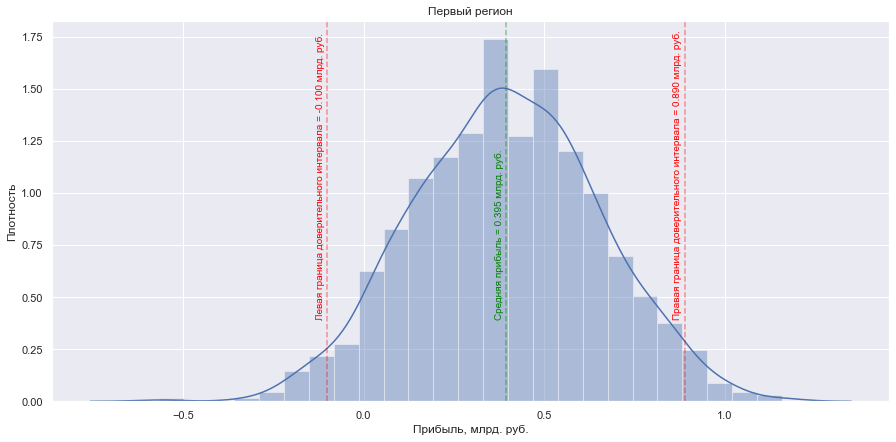

Средняя прибыль = 0.395 млрд. руб.
Доверительный интервал 95% = [-0.100, 0.890]
Вероятность получить убыток равна 5.2%


c:\users\delle\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


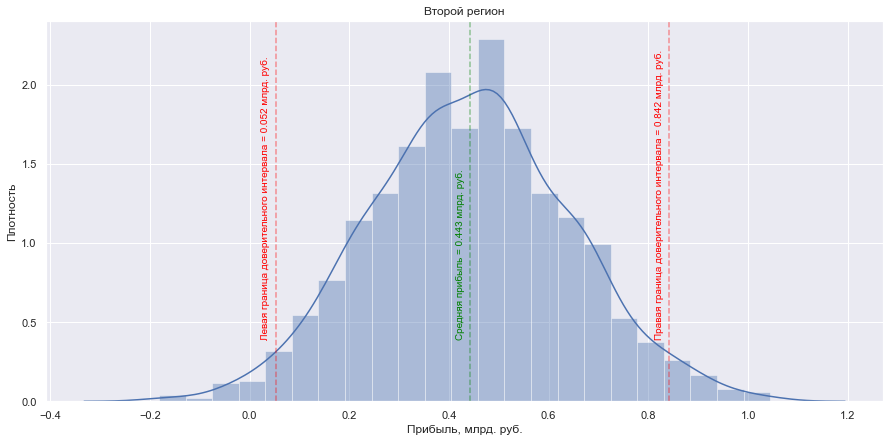

Средняя прибыль = 0.443 млрд. руб.
Доверительный интервал 95% = [0.052, 0.842]
Вероятность получить убыток равна 1.3%


c:\users\delle\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


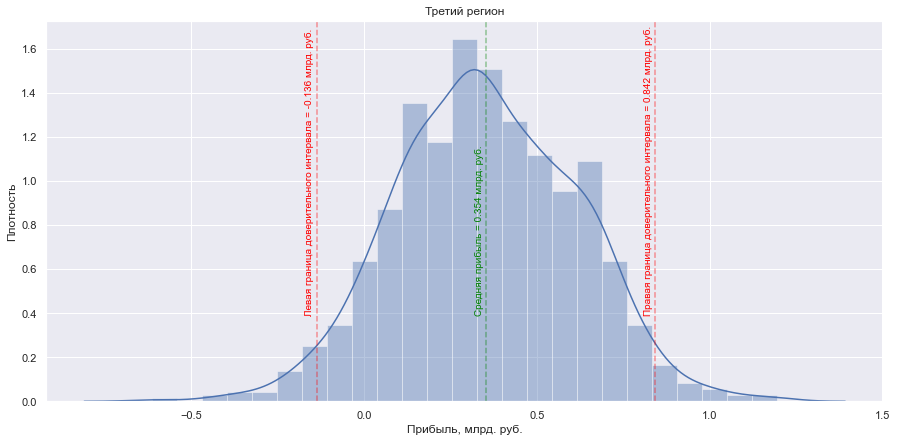

Средняя прибыль = 0.354 млрд. руб.
Доверительный интервал 95% = [-0.136, 0.842]
Вероятность получить убыток равна 8.0%


In [16]:
# Создадим RandomState
state = np.random.RandomState(rand_state)

sns.set()

# Функция добавления вертикальной линии на график
def vert_line(x, ax, color, text):
    plt.axvline(x, color=color, linestyle='dashed', alpha=.4)
    ax.text(x-.02,
            0.4, str(text)+' = {:.3f} млрд. руб.'.format(x),
            color=color,
            size=10,
            rotation=90,
            ha='center'
           )

# Напишем функцию бутстрапа
def distr_calc(target, predictions, region):
    values = []
    for i in range(1000):
        # Получим 500 произвольных скважин из региона
        bootstrap_pred = predictions.sample(n=500, replace=True, random_state=state)
        # Найдем реальные значения для выбранных скважин
        bootstrap_targ = target.loc[bootstrap_pred.index]
        # Добавим значение прибыли в список
        values.append(revenue_calc(bootstrap_targ, bootstrap_pred, WELL_COUNT, False))
    # Для простоты сделаем список объектом pd.Series()
    values = pd.Series(values)
    # Рассчитаем среднюю прибыль
    values_mean = values.mean()
    # Определим 95% доверительный интервал
    q_025 = values.quantile(0.025)
    q_975 = values.quantile(0.975)  
    # Рассчитаем вероятность убытка
    p_loss = (values<0).mean()
   
    # Построим гистограмму распределения прибыли, нанесем на неё среднее значение
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 7)
    sns.distplot(values, ax=ax)
    ax.set(xlabel='Прибыль, млрд. руб.', ylabel='Плотность', title=region)
    vert_line(values_mean, ax, 'green', 'Средняя прибыль')
    vert_line(q_025, ax, 'red', 'Левая граница доверительного интервала')
    vert_line(q_975, ax, 'red', 'Правая граница доверительного интервала')
    
#     plt.axvline(values_mean, color='red', linestyle='dashed', alpha=.4)
    
#     ax.text(values_mean-.02,
#             0.2, 'Средняя прибыль = {:.3f} млрд. руб.'.format(values_mean),
#             color='red',
#             size=10,
#             rotation=90,
#             ha='center'
#            )
    plt.show()
    
    print('Средняя прибыль = {:.3f} млрд. руб.'.format(values_mean))
    print('Доверительный интервал 95% = [{:.3f}, {:.3f}]'.format(q_025, q_975))
    print('Вероятность получить убыток равна {:.1%}'.format(p_loss))
    return values

revenue_1 = distr_calc(target_1, predictions_1, 'Первый регион')
revenue_2 = distr_calc(target_2, predictions_2, 'Второй регион')
revenue_3 = distr_calc(target_3, predictions_3, 'Третий регион')

### Вывод

Из полученных данных можно сделать вывод, что разработка скважин в первом или третьем регионе рискованна, т.к. вероятность получить убыток больше 2,5%. Таким образом для разработки выбираем второй регион, средняя прибыль которого составляет 0,443 млрд. руб.

### Общий вывод

В ходе работы были получены следующие результаты:
1. Исходные данные предобработаны
2. Были обучены модели для прогнозирования объемов запасов нефти в каждом регионе. Качество модели получилось больше всего у модели для второго региона
3. Был определен средний объем запасов нефти, необходимый для безубыточной разработки региона. На основе этих данных было сделано неверное предположение, что первый и третий регион являются более перспективными для разработки
4. На основе предсказанных данных были определены объемы запасов и прибыль с лучших скважин в каждом регионе, выбранных на основе предсказаний модели. Лучшим получился первый регион
5. С применением техники bootstrap было получено среднее значение прибыли для каждого региона, определены 95% доверительные интервалы и рассчитаны риски убытков. С учетом полученных данных наиболее перспективным оказался второй регион, средняя прибыль в котором составила 0,443 млрд. руб, а разработка скважин в первом или третьем регионе рискованна.